In [ ]:
# Example notebook to post-process and combine WRF results for wind farm power outputs

# The example shown is for power output in a wind farm in the small Denmark domain

In [1]:
# import necessary packages

import pandas as pd
import numpy as np
import glob
import pylab as plt
import random

In [2]:
# read in norm of initial wind velocity at future location of hypothetical wind farm
df_vel_norm = pd.read_csv('vel_avg_norm.csv')

# read in arbitrary file to get location of wind farm array
farm_array = np.load("/rds/general/project/wrfwindpower/live/wrf_results_square/fixed_farm/200701_01/power.npy")

In [23]:
# read in theoretical power curve of wind turbines used

from scipy.interpolate import interp1d
f = open('power_curve.txt').read()
power_file = [line.split(' ') for line in f.split('\n')]
vel_txt = [0]
for i in power_file[:-1]:
    vel_txt.append(float(i[0]))
for _ in range(10):
    vel_txt.append(vel_txt[-1]+1)
power_txt = [0]
for i in power_file[:-1]:
    power_txt.append(float(i[2]))
for _ in range(10):
    power_txt.append(power_txt[-1])
power_curve = interp1d(vel_txt, [i*1000 for i in power_txt])

power_curve_power = power_curve(df_vel_norm['norm_vel']).sum()*136

In [4]:
# read in outputs from WRF simulations for whole of 2007 - this is what we use as the truth

fname_fixed_list = []
power_fixed_list = []

path = "/rds/general/project/wrfwindpower/live/wrf_results_square/fixed_farm/*/"

path_txt = str(path) + '/power.npy'
for fname in glob.glob(path_txt):
    fname_fixed_list.append(fname)

fname_fixed_list.sort()

for i in fname_fixed_list:
    power_fixed_list.append(np.load(i))


In [6]:
# load in WRF outputs for the closest datapoints to the cluster centres for cluster found by clustering
# on wind velocity on Europe-wide domain

def load_file(folder_init, file_init):
    folder = '/rds/general/project/wrfwindpower/live/' + folder_init
    cluster_0 = np.load(folder + '_0/' + file_init + '.npy')
    cluster_1 = np.load(folder + '_1/' + file_init + '.npy')
    cluster_2 = np.load(folder + '_2/' + file_init + '.npy')
    cluster_3 = np.load(folder + '_3/' + file_init + '.npy')
    cluster_4 = np.load(folder + '_4/' + file_init + '.npy')
    cluster_5 = np.load(folder + '_5/' + file_init + '.npy')
    
    return cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5

power_cluster_0_wind_d01, power_cluster_1_wind_d01, power_cluster_2_wind_d01,\
    power_cluster_3_wind_d01, power_cluster_4_wind_d01, power_cluster_5_wind_d01 = load_file('wrf_results_wind_d01/fixed_sq_farm', 'power')

u1_cluster_0_wind_d01, u1_cluster_1_wind_d01, u1_cluster_2_wind_d01,\
    u1_cluster_3_wind_d01, u1_cluster_4_wind_d01, u1_cluster_5_wind_d01 = load_file('wrf_results_wind_d01/fixed_sq_farm', 'u')

u2_cluster_0_wind_d01, u2_cluster_1_wind_d01, u2_cluster_2_wind_d01,\
    u2_cluster_3_wind_d01, u2_cluster_4_wind_d01, u2_cluster_5_wind_d01 = load_file('wrf_results_wind_d01/fixed_sq_farm', 'v')

# estimate the norm of the velocity at the location of the wind farm
norm_vel_0_wind_d01 = np.sqrt((u1_cluster_0_wind_d01[0, 11, :, :72])**2 + (u2_cluster_0_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()
norm_vel_1_wind_d01 = np.sqrt((u1_cluster_1_wind_d01[0, 11, :, :72])**2 + (u2_cluster_1_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()
norm_vel_2_wind_d01 = np.sqrt((u1_cluster_2_wind_d01[0, 11, :, :72])**2 + (u2_cluster_2_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()
norm_vel_3_wind_d01 = np.sqrt((u1_cluster_3_wind_d01[0, 11, :, :72])**2 + (u2_cluster_3_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()
norm_vel_4_wind_d01 = np.sqrt((u1_cluster_4_wind_d01[0, 11, :, :72])**2 + (u2_cluster_4_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()
norm_vel_5_wind_d01 = np.sqrt((u1_cluster_5_wind_d01[0, 11, :, :72])**2 + (u2_cluster_5_wind_d01[0, 11, :153, :])**2)[farm_array[-1]!=0].mean()

/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in arccos
/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos
/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos


In [ ]:
# split real power values for each day in 2007 by regime
df_wind_d01 = pd.read_csv('labels_all_6_wind_d01.csv')
df_2007_wind_d01 = df_wind_d01[df_wind_d01['Year'] == 2007].reset_index(drop = True)

final_fixed_power = [i[-1].sum() for i in power_fixed_list]

combined_wind_d01 = pd.concat([df_2007_wind_d01, df_vel_norm], join = 'inner', axis = 1)

reg_fixed_power_wind_d01 = pd.concat([combined_wind_d01[['Regime', 'norm_vel']], pd.DataFrame(final_fixed_power)], axis = 1)

reg_fixed_power_0_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 0].reset_index(drop = True)
reg_fixed_power_1_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 1].reset_index(drop = True)
reg_fixed_power_2_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 2].reset_index(drop = True)
reg_fixed_power_3_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 3].reset_index(drop = True)
reg_fixed_power_4_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 4].reset_index(drop = True)
reg_fixed_power_5_wind_d01 = reg_fixed_power_wind_d01[reg_fixed_power_wind_d01['Regime'] == 5].reset_index(drop = True)

In [ ]:
## Compare the power predictions for each different method assessed in the paper

# WRF is used as the real value, and then we have three separate methods of combining a reduced number 
# of WRF runs

# Here we show the power predictions in the Denmark domain for the clusters obtained by clustering wind velocity 
# on the Europe-wide domain but the code would be the same for the other domains

# The plot in the paper is slightly different as it combines all the results from the different clusters for each domain

92995407243.39062
83077128877.33334
91764363366.70206
102165465519.0


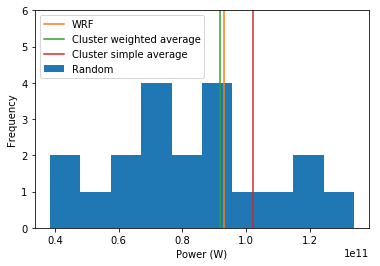

In [11]:
# Calculate power prediction from selecting 6 datapoints from the dataset randomly
# This is done 20 times and then averaged, and is used to show the results that could be obtained
# if datapoints were picked randomly instead of found using a robust clustering approach


avg_fixed_power = []
for i in range(int(np.floor(20))):
    avg_fixed_power.append(np.sum([final_fixed_power[i] for i in [random.randint(0, 364) for _ in range(6)]])*365/6)
    
plt.hist(avg_fixed_power, label = 'Random')

# Calculate the real power output for every datapoint in 2007
plt.plot([reg_fixed_power_wind_d01[0].sum() for _ in range(16)], [i for i in range(16)], label = 'WRF')
print(reg_fixed_power[0].sum())
print(np.mean(avg_fixed_power))

# Calculate power prediction using the more complex weighted approach
power_0_factor_wind_d01 = power_cluster_0_wind_d01[-1].sum()*reg_fixed_power_0_wind_d01['norm_vel']/norm_vel_0_wind_d01
power_0_factor_wind_d01[power_0_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()
power_1_factor_wind_d01 = power_cluster_1_wind_d01[-1].sum()*reg_fixed_power_1_wind_d01['norm_vel']/norm_vel_1_wind_d01
power_1_factor_wind_d01[power_1_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()
power_2_factor_wind_d01 = power_cluster_2_wind_d01[-1].sum()*reg_fixed_power_2_wind_d01['norm_vel']/norm_vel_2_wind_d01
power_2_factor_wind_d01[power_2_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()
power_3_factor_wind_d01 = power_cluster_3_wind_d01[-1].sum()*reg_fixed_power_3_wind_d01['norm_vel']/norm_vel_3_wind_d01
power_3_factor_wind_d01[power_3_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()
power_4_factor_wind_d01 = power_cluster_4_wind_d01[-1].sum()*reg_fixed_power_4_wind_d01['norm_vel']/norm_vel_4_wind_d01
power_4_factor_wind_d01[power_4_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()
power_5_factor_wind_d01 = power_cluster_5_wind_d01[-1].sum()*reg_fixed_power_5_wind_d01['norm_vel']/norm_vel_5_wind_d01
power_5_factor_wind_d01[power_5_factor_wind_d01 > reg_fixed_power[0].max()] = reg_fixed_power[0].max()

fix_power_sum_wind_d01 = 0
fix_power_sum_wind_d01 += power_0_factor_wind_d01.sum()
fix_power_sum_wind_d01 += power_1_factor_wind_d01.sum()
fix_power_sum_wind_d01 += power_2_factor_wind_d01.sum()
fix_power_sum_wind_d01 += power_3_factor_wind_d01.sum()
fix_power_sum_wind_d01 += power_4_factor_wind_d01.sum()
fix_power_sum_wind_d01 += power_5_factor_wind_d01.sum()

print(fix_power_sum_wind_d01)

plt.plot([fix_power_sum_wind_d01 for _ in range(16)], [i for i in range(16)], label = 'Cluster weighted average')

# Calculate the power output from using the simple averaged approach
fix_power_sum_wind_d01_simple = 0
fix_power_sum_wind_d01_simple += power_cluster_0_wind_d01[-1].sum()*len(reg_fixed_power_0_wind_d01)
fix_power_sum_wind_d01_simple += power_cluster_1_wind_d01[-1].sum()*len(reg_fixed_power_1_wind_d01)
fix_power_sum_wind_d01_simple += power_cluster_2_wind_d01[-1].sum()*len(reg_fixed_power_2_wind_d01)
fix_power_sum_wind_d01_simple += power_cluster_3_wind_d01[-1].sum()*len(reg_fixed_power_3_wind_d01)
fix_power_sum_wind_d01_simple += power_cluster_4_wind_d01[-1].sum()*len(reg_fixed_power_4_wind_d01)
fix_power_sum_wind_d01_simple += power_cluster_5_wind_d01[-1].sum()*len(reg_fixed_power_5_wind_d01)

print(fix_power_sum_wind_d01_simple)

plt.plot([fix_power_sum_wind_d01_simple for _ in range(16)], [i for i in range(16)], label = 'Cluster simple average')
plt.ylim([0, 6])
plt.xlabel('Power (W)')
plt.ylabel('Frequency')
plt.legend()
plt.show()